## アジェンダ

- 手法ベースの比較をする
- 特徴量ベースの比較
- チューニングする
- データセットを増やして比較する
    - ラベルが増えた場合(Mythica)
      - <https://dreamtolearn.com/ryan/data_analytics_viz/18>
    - データが増えた場合
      - 仮想のデータを作る
      

## 目的

- Irisデータセットを用いて簡単にMLFlow管理を実践する

## モジュールのインポート

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tqdm import tqdm

## データセットの読み込み

In [2]:
# データセットの読み込み
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)
df['target_label'] = y.map(lambda x: 'setosa' if x == 0 else "versicolor" if x == 1 else "virginica")
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


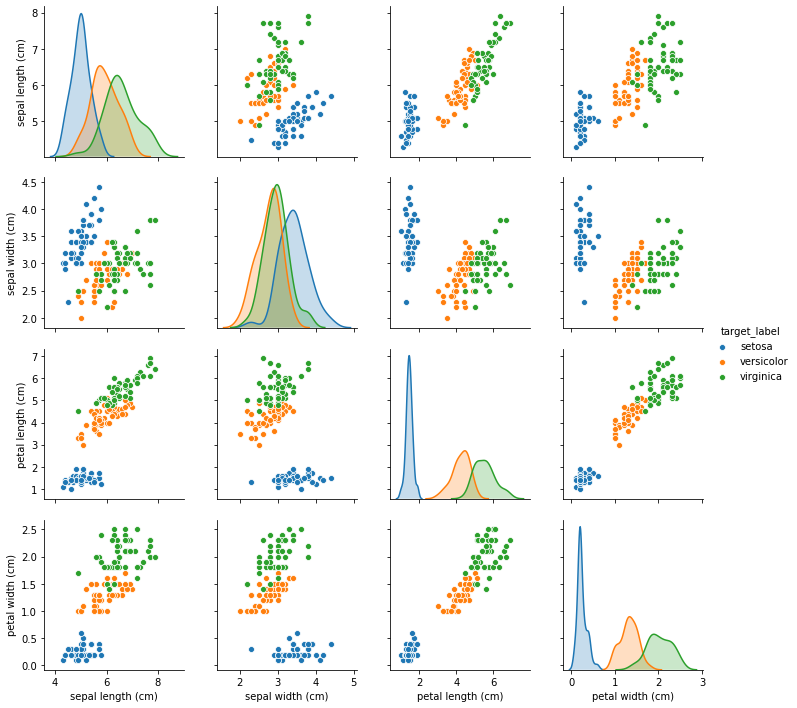

In [3]:
# データセットの各特徴量同士の相関を見る
sns.pairplot(df, hue='target_label')

## 簡単に学習させる

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-2], y, test_size=0.3, random_state=98)

In [5]:
clf = RandomForestClassifier(max_depth=3, random_state=98)
clf.fit(X_train, y_train)

/Users/shingo.tawada/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=98, verbose=0,
                       warm_start=False)

## 学習結果を評価する

In [6]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    return rmse, mae

In [7]:
y_pred = clf.predict(X_test)
rmse, mae = eval_metrics(y_test, y_pred)
print('Train score: {:.3f}'.format(clf.score(X_train, y_train)))
print('Test score: {:.3f}'.format(clf.score(X_test, y_test)))
print('Error score: \n\trmse:{:.3f}\n\tmae:{:.3f}'.format(rmse, mae))
print('Classification report: \n{}'.format(classification_report(y_test, y_pred)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))

Train score: 0.981
Test score: 0.867
Error score: 
	rmse:0.365
	mae:0.133
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.68      0.81        19
           2       0.71      1.00      0.83        15

    accuracy                           0.87        45
   macro avg       0.90      0.89      0.88        45
weighted avg       0.90      0.87      0.87        45

Confusion matrix:
[[11  0  0]
 [ 0 13  6]
 [ 0  0 15]]


## 学習結果をMLFlowで管理する

MLFlow起動時はディレクトリを変えて行う

```shell
cd notebooks
mlflow ui
```

In [8]:
experiment_id = mlflow.create_experiment("RandomForest Classifer")
print("Experiment id: {}".format(experiment_id))

Experiment id: 1


In [9]:
with mlflow.start_run(experiment_id=experiment_id):
    clf = RandomForestClassifier(random_state=98)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    rmse, mae = eval_metrics(y_test, y_pred)
    
    mlflow.log_param("Train score", clf.score(X_train, y_train))
    mlflow.log_param("Test score", clf.score(X_test, y_test))
    mlflow.log_param("Test Accuracy", accuracy_score(y_test, clf.predict(X_test)))
    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)

    mlflow.sklearn.log_model(clf, "model")

/Users/shingo.tawada/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


実行するとMLFlowにモデルとパラメータが保存されるので確認しましょう。

<http://localhost:5000/>

## 複数手法を試してみる
sklearnに含まれている他の手法を試して、MLFlow上で比較してみましょう

### SVM Classifier を試してみる

In [10]:
experiment_id = mlflow.create_experiment("SVM Classifier")
print("Experiment id: {}".format(experiment_id))

Experiment id: 2


In [11]:
with mlflow.start_run(experiment_id=experiment_id):
    cls = SVC(random_state=98)
    cls.fit(X_train, y_train)
    
    y_pred = cls.predict(X_test)
    rmse, mae = eval_metrics(y_test, y_pred)
    
    mlflow.log_param("Train score", cls.score(X_train, y_train))
    mlflow.log_param("Test score", cls.score(X_test, y_test))
    mlflow.log_param("Test Accuracy", accuracy_score(y_test, y_pred))
    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)

    mlflow.sklearn.log_model(cls, "model")

/Users/shingo.tawada/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Naive bayes 分類機 を 試してみる

In [12]:
experiment_id = mlflow.create_experiment("Naive bayes Classifier")
print("Experiment id: {}".format(experiment_id))

Experiment id: 3


In [13]:
with mlflow.start_run(experiment_id=experiment_id):
    cls = GaussianNB()
    cls.fit(X_train, y_train)
    
    y_pred = cls.predict(X_test)
    rmse, mae = eval_metrics(y_test, y_pred)
    
    mlflow.log_param("Train score", cls.score(X_train, y_train))
    mlflow.log_param("Test score", cls.score(X_test, y_test))
    mlflow.log_param("Test Accuracy", accuracy_score(y_test, cls.predict(X_test)))
    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)

    mlflow.sklearn.log_model(cls, "model")

今回はSVMが一番効果あるアルゴリズムということがわかった(本当はちゃんとデータを見て検討するべき)

## パラメータチューニングをMLFlowで管理する

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
# SVC用のパラメータを準備する
cv = 3

tuned_parameters = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
]

In [19]:
experiment_id = mlflow.create_experiment("SVC Parameter Tuning")
print("Experiment id: {}".format(experiment_id))

Experiment id: 4


In [25]:
for tuned_param in tqdm(tuned_parameters):
    with mlflow.start_run(experiment_id=experiment_id):
        cls = SVC(random_state=98)
        grid = GridSearchCV(estimator=cls, scoring='accuracy', param_grid=tuned_param, cv=cv, verbose=1, n_jobs=-1)
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)
        rmse, mae = eval_metrics(y_test, y_pred)
        
        print(grid.best_params_)
        
        mlflow.log_param("C", grid.best_params_['C'])
        if 'gamma' in list(tuned_param.keys()):
            mlflow.log_param('gamma', grid.best_params_['gamma'])
        if 'kernel' in list(tuned_param.keys()):
            mlflow.log_param('kernel', grid.best_params_['kernel'])
        
        mlflow.log_param("Train score", grid.score(X_train, y_train))
        mlflow.log_param("Test score", grid.score(X_test, y_test))
        mlflow.log_param("Test Accuracy", accuracy_score(y_test, y_pred))

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(cls, "model")

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    1.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.6s finished
/Users/shingo.tawada/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
 25%|██▌       | 1/4 [00:02<00:06,  2.22s/it]

{'C': 1, 'kernel': 'linear'}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.7s finished
/Users/shingo.tawada/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
 50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.7s finished
/Users/shingo.tawada/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
 75%|███████▌  | 3/4 [00:06<00:02,  2.25s/it]

{'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.7s finished
/Users/shingo.tawada/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
100%|██████████| 4/4 [00:09<00:00,  2.26s/it]

{'C': 1000, 'gamma': 0.001, 'kernel': 'sigmoid'}


最適パラメータがおそらくこんな感じになっているはず

|Name|Value|
|---|---|
|C|1000|
|gamma|0.001|
|kernel|rbf|
|Test Accuracy|0.9555555555555556|
|Test score|0.9555555555555556|
|Train score|0.9714285714285714|


## データが追加された場合

### 突然のコンペ

あなたはデータアナリストです。Irisデータをつかって高精度を出したところ、「追加のデータがあるからこれを使ったらもっと精度上がらないかな？」という提案を持ちかけられました。データが増えれば精度が上がると思った営業はアナリストより先に「できます！やりましょう！」と答えてしまったため、データを見る前にあなたは追加されたデータで精度を上げる必要が出てしまいました。

data ディレクトリに `iris_extend_data_*.csv` で始まるデータがあります。こちらの5つのデータを適切に加えたり前処理して精度向上させてみましょう。

### ルール
- 最重要
    - MLFlowを使ってパラメータやメトリクスを必ず保存すること

- 基本的なirisデータセットとextendは必ず使って精度を向上させること(つまりパラメータチューニングしたTest Accuracyである95.55を超えてほしい)
- 使用アルゴリズムは何を使用してもいいです。特別制限はありません。

- 余裕がある人は `iris_extend_data_*.csv` にある5つのデータをうまく分析して「学習データに不向きなデータ」「学習データにするための適切な前処理」が何かを探してみましょう。